In [28]:
import numpy as np
import mdtraj as md
import os

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [9]:
works_dict = {}
for phase in ['solvent', 'complex']:
    for side in ['new', 'old']:
        for steps in [1, 500]:
            try:
                detail = np.load(os.path.join(os.getcwd(), f"{phase}_{steps}_steps/{side}.works.npy"), allow_pickle=True)
                works_dict[f'{phase}.{steps}.{side}'] = detail.item()
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: '/mnt/c/Users/domin/scratch/temp_nn_endstates/wrapper/solvent_1_steps/old.works.npy'


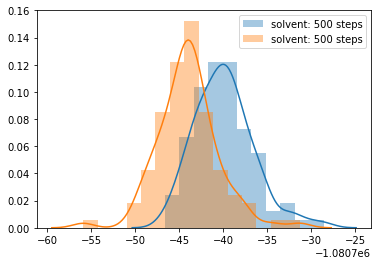

In [55]:
#sns.distplot([val[-1] for val in works_dict['solvent.1.old'].values()], label = f'solvent: instantaneous')
sns.distplot([val[-1] for val in works_dict['solvent.500.old'].values()], label = f'solvent: 500 steps')
sns.distplot([val[-1] for val in works_dict['solvent.500.new'].values()], label = f'solvent: 500 steps')
plt.legend()

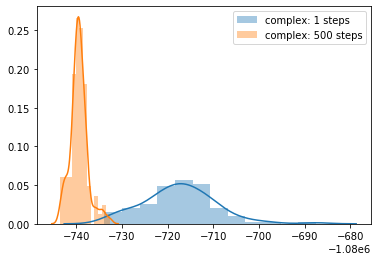

In [70]:
#sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: instantaneous')
sns.distplot([val[-1] for val in works_dict['complex.1.old'].values()], label = 'complex: 1 steps')
sns.distplot([val[-1] for val in works_dict['complex.500.old'].values()], label = 'complex: 500 steps')
plt.legend()

i am going to spell out how the free energy correction should be done. 
We know that the relative free energy of 'ligXtoY' is measured as dg_X - dg_Y; 
we also know that RT = 0.593 kcal/mol at 298K; <br>
first, let's plot the perses vs experimental results

In [24]:
perses_dgs = np.load('/mnt/c/Users/domin/scratch/temp_nn_endstates/perses_calc_dgs.npy', allow_pickle=True).item()
experimental_dgs = np.load('/mnt/c/Users/domin/scratch/temp_nn_endstates/exp_calc_dgs.npy', allow_pickle=True).item()

In [25]:
keys = perses_dgs.keys()
perses, calcs, perses_error = [], [], []
for key in keys:
    perses.append(perses_dgs[key][0])
    perses_error.append(perses_dgs[key][1])
    calcs.append(experimental_dgs[key])

Text(0, 0.5, '$\\Delta G_{calculation, MM}$ $[kT]$')

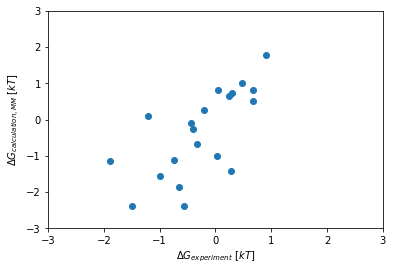

In [64]:
plt.scatter(calcs, perses)
slope, intercept, rval, pval, stderr = linregress(calcs, perses)
space = np.linspace(min(calcs), max(calcs), 100)
#plt.plot(space, space*slope + intercept)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$\Delta G_{experiment}$ $[kT]$')
plt.ylabel('$\Delta G_{calculation, MM}$ $[kT]$')

since we have $\Delta G_{MM} = \Delta G_{1, MM} - \Delta G_{2, MM}$, we can say that $\Delta G_{1, ANI} - \Delta G_{2, ANI} =  \Delta G_{MM}  + \left(  \Delta G_{complex, old} - \Delta G_{solvent, old}\right) - \left(  \Delta G_{complex, new} - \Delta G_{solvent, new} \right)$

In [37]:
from pymbar import EXP
dg_complex_old, ddg_complex_old = EXP(np.array([val[-1] for val in works_dict['complex.500.old'].values()]))
dg_complex_new, ddg_complex_new = EXP(np.array([val[-1] for val in works_dict['complex.500.new'].values()]))
dg_solvent_old, ddg_solvent_old = EXP(np.array([val[-1] for val in works_dict['solvent.500.old'].values()]))
dg_solvent_new, ddg_solvent_new = EXP(np.array([val[-1] for val in works_dict['solvent.500.new'].values()]))

In [71]:
ddg_complex_old

0.22065025489998402

In [72]:
ddg_solvent_old

0.35163691664713687

In [68]:
dg_complex_new -dg_complex_old

-1.48051657830365

In [62]:
(dg_complex_old - dg_solvent_old)/0.593

4.044486422556599

In [63]:
(dg_complex_new - dg_solvent_new)/0.593

15.071674821345516

In [57]:
binding_dg = perses_dgs[(0,2)][0]
ani_binding_dg = binding_dg + (dg_complex_old - dg_solvent_old)/0.593 - (dg_complex_new - dg_solvent_new)/0.593

In [58]:
ani_binding_dg

-12.035852260386434

In [59]:
ani_error = np.sqrt(perses_dgs[(0,2)][1]**2 + (ddg_solvent_old/0.593)**2 + (ddg_solvent_new/0.593)**2 + (ddg_complex_old/0.593)**2 + (ddg_complex_new/0.593)**2)

In [60]:
ani_error

1.8222523448746186

In [61]:
experimental_dgs[(0,2)]

0.028821999999999903

todo:
1. check ani forces
2. check thermocycle and free energy correction